# Benchmarking full and chunked file reading

In this notebook, a benchmark on three file types (DAT, EVT2 and EVT3) is run, comparing expelliarmus and metavision.

In [1]:
from expelliarmus import Wizard
from metavision_core.event_io import EventsIterator, RawReader
from metavision_core.event_io.py_reader import EventDatReader
import pathlib
import h5py
import numpy as np
import timeit
import requests
import pickle

FIRST_RUN = True
SAVE_RESULTS = True
LOAD_RESULTS = False
REPEAT = 10

## setup

In [2]:
get_fsize_MB = lambda fpath: round(fpath.stat().st_size/(1024*1024))

In [3]:
fname = "driving_sample"
get_fpath = lambda encoding: f"{fname}_{encoding}.{'raw' if encoding!='dat' else 'dat'}"

if FIRST_RUN:
    # Downloading files.
    print("Downloading EVT3 file... ", end="")
    if not pathlib.Path(get_fpath('evt3')).is_file():
        r = requests.get("https://dataset.prophesee.ai/index.php/s/nVcLLdWAnNzrmII/download", allow_redirects=True) # spinner.dat, DAT
        with open(get_fpath('evt3'), 'wb') as f:
            f.write(r.content)
    print("done!")

converting files

In [4]:
softwares = ("hdf5", "hdf5_lzf", "hdf5_gzip", "numpy")
encodings = ("dat", "evt2", "evt3")

print("Converting the EVT3 file to EVT2 and DAT formats... ", end="")
wizard = Wizard(encoding="evt3")
evt3_arr = wizard.read(get_fpath('evt3'))
for encoding in ("dat", "evt2"):
    wizard.set_encoding(encoding)
    wizard.save(fpath=get_fpath(encoding), arr=evt3_arr)
print("done!")

Converting the EVT3 file to EVT2 and DAT formats... done!


In [5]:
EMPTY_DICT = dict(fsize=0, full=0, windowed=0, chunked=0)
data = dict(
    expelliarmus = dict(dat=EMPTY_DICT, evt2=EMPTY_DICT, evt3=EMPTY_DICT),
    metavision = dict(dat=EMPTY_DICT, evt2=EMPTY_DICT, evt3=EMPTY_DICT),
    hdf5 = EMPTY_DICT,
    hdf5_lzf = EMPTY_DICT,
    hdf5_gzip = EMPTY_DICT,
    numpy = dict(fsize=0, full=0),
)

## run benchmarking

### benchmarking for expelliarmus

In [7]:
if LOAD_RESULTS:
    data = pickle.load(open("./benchmark.pk", "rb"))

for encoding in encodings:
    if not LOAD_RESULTS:  
        fpath = pathlib.Path(get_fpath(encoding))
        wizard.set_encoding(encoding)
        wizard.set_file(fpath)
        if FIRST_RUN:
            arr = wizard.read()
            
        data["expelliarmus"][encoding]["fsize"] = get_fsize_MB(fpath)       
        data["expelliarmus"][encoding]["full"] = sum(timeit.repeat(lambda: wizard.read(), number=1, repeat=REPEAT))/REPEAT
        print(f'{encoding:>4}: {data["expelliarmus"][encoding]["full"]:.2f}s')

 dat: 0.90s
evt2: 0.86s
evt3: 1.83s


### benchmarking for metavision

In [8]:
def metavision_read_raw(rawreader, n_skip=10_000_000):
    rawreader.reset()
    while not rawreader.done:
        rawreader.seek_event(n_skip)
    n_events = rawreader.current_event_index()
    rawreader.reset()
    return rawreader.load_n_events(n_events)

def metavision_read_dat(datreader):
    return datreader.load_n_events(datreader.event_count())

def metavision_read_raw_iterator(eviterator, delta_t=10_000):
    return [ev for ev in eviterator]

In [9]:
# n_events: 111_484_516
# lower bound: 2 bytes per event
# upper bound: 9 bytes per event
REPEAT = 3
if not LOAD_RESULTS:
    for encoding in encodings:
        fpath = pathlib.Path(get_fpath(encoding))
#         print(encoding, fpath, '\n', '-'*30, sep='', end='\n\n')
        
        data['metavision'][encoding]['fsize'] = get_fsize_MB(fpath)

        if encoding == 'evt2':
            data['metavision'][encoding]['full'] = 100
            continue # TODO: skip for now (waiting for separate bugfix)
        elif 'evt' in encoding:
            N_SKIP = int(1e7)
            MAX_EVENTS = int(1e9)
            raw_reader = RawReader(str(fpath), max_events=MAX_EVENTS)
            raw_fn = lambda: metavision_read_raw(raw_reader, n_skip=N_SKIP)
        elif encoding == 'dat':
            dat_reader = EventDatReader(str(fpath))
            raw_fn = lambda: metavision_read_dat(dat_reader)

        raw_duration = sum(timeit.repeat(raw_fn, number=1, repeat=REPEAT)) / REPEAT
        print(f'[{encoding}] duration (direct): {raw_duration:.2f}s')

        DELTA_T = 10000
        evit_reader = EventsIterator(str(fpath), delta_t=DELTA_T)
        evit_fn = lambda: [ev for ev in evit_reader]

        evit_duration = sum(timeit.repeat(evit_fn, number=1, repeat=REPEAT)) / REPEAT
        print(f'[{encoding}] duration (iterator): {evit_duration:.2f}s')

        data['metavision'][encoding]['full'] = min(raw_duration, evit_duration)

[dat] duration (raw): 0.55s
[dat] duration (iterator): 7.15s
[evt3] duration (raw): 4.56s
[evt3] duration (iterator): 1.99s


### benchmarking for HDF5 and NPY formats

In [10]:
if FIRST_RUN:
    for sw in softwares[:-1]:
        fpath = pathlib.Path(f"ref_{sw}.hdf5")
        fp = h5py.File(fpath, "w")
        if sw=="hdf5":
            arr_hdf5 = fp.create_dataset("arr", arr.shape, arr.dtype)
        elif sw=="hdf5_lzf":
            arr_hdf5 = fp.create_dataset("arr", arr.shape, arr.dtype, compression="lzf")
        elif sw=="hdf5_gzip":
            arr_hdf5 = fp.create_dataset("arr", arr.shape, arr.dtype, compression="gzip")
            
        arr_hdf5[:] = arr[:]
        fp.close()
        data[sw]["fsize"] = get_fsize_MB(fpath)
        fp = h5py.File(fpath)
        data[sw]["full"] = sum(timeit.repeat(lambda: fp["arr"][:], number=1, repeat=REPEAT))/REPEAT
        fp.close()
        print(f'{sw}: {data[sw]["full"]:.2f}s')

    # NumPy
    fpath = pathlib.Path("ref_np.npy")
    np.save(fpath, arr, allow_pickle=False)
    data["numpy"]["fsize"] = get_fsize_MB(fpath)
    data["numpy"]["full"] = sum(timeit.repeat(lambda: np.load(fpath), number=1, repeat=REPEAT))/REPEAT
    print(f'numpy: {data["numpy"]["full"]:.2f}s')

hdf5: 0.79s
hdf5_lzf: 2.94s
hdf5_gzip: 5.17s
numpy: 0.46s


## benchmarking results

In [11]:
def get_diff_perc_str(ref, val):
    if (val > ref):
        return f"+{round((val/ref-1)*100):>3}%"
    else:
        return f"-{round((1-val/ref)*100):>3}%"

In [12]:
def gen_row(sw_name, size_value, time_value, mode):
    exp_dict = data["expelliarmus"]
    dat_fsize, evt2_fsize, evt3_fsize = exp_dict["dat"]["fsize"], exp_dict["evt2"]["fsize"], exp_dict["evt3"]["fsize"]
    dat_time, evt2_time, evt3_time = exp_dict["dat"][mode], exp_dict["evt2"][mode], exp_dict["evt3"][mode]
    return_str = f'{sw_name:<9} | {size_value:<9} | ' + \
                 f'{get_diff_perc_str(dat_fsize, size_value):<9} | ' + \
                 f'{get_diff_perc_str(evt2_fsize, size_value):<10} | ' + \
                 f'{get_diff_perc_str(evt3_fsize, size_value):<10} | ' + \
                 f'{time_value:<9.2f} | ' + \
                 f'{get_diff_perc_str(dat_time, time_value):<8} | ' +\
                 f'{get_diff_perc_str(evt2_time, time_value):<10} | ' + \
                 f'{get_diff_perc_str(evt3_time, time_value):<8}'
    return return_str

header = "Software  | Size [MB] | Diff. DAT | Diff. EVT2 | Diff. EVT3 | Time [s] | " +\
         "Diff. DAT | Diff. EVT2 | Diff. EVT3"
print("-"*len(header))
print(header)
print("-"*len(header))

for encoding in encodings:
    print(gen_row(f"exp. {encoding.upper()}", data["expelliarmus"][encoding]["fsize"], data["expelliarmus"][encoding]["full"], "full"))
    print("-"*len(header))

for encoding in encodings:
    print(gen_row(f"met. {encoding.upper()}", data["metavision"][encoding]["fsize"], data["metavision"][encoding].get("full", 100), "full"))
    print("-"*len(header))
    
for sw in softwares: 
    print(gen_row(sw, data[sw]["fsize"], data[sw]["full"], "full"))
    print("-"*len(header))

------------------------------------------------------------------------------------------------------------
Software  | Size [MB] | Diff. DAT | Diff. EVT2 | Diff. EVT3 | Time [s] | Diff. DAT | Diff. EVT2 | Diff. EVT3
------------------------------------------------------------------------------------------------------------
exp. DAT  | 851       | -  0%     | +100%      | +143%      | 0.90      | -  0%    | +  5%      | - 51%   
------------------------------------------------------------------------------------------------------------
exp. EVT2 | 426       | - 50%     | -  0%      | + 22%      | 0.86      | -  5%    | -  0%      | - 53%   
------------------------------------------------------------------------------------------------------------
exp. EVT3 | 350       | - 59%     | - 18%      | -  0%      | 1.83      | +104%    | +114%      | -  0%   
------------------------------------------------------------------------------------------------------------
met. DAT  | 851       | -

***TODO: separate tables for metavision comparison and different file format comparison***

## Plotting results

***TODO: update with metavision results***

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('classic')
%matplotlib inline

<Figure size 432x288 with 0 Axes>

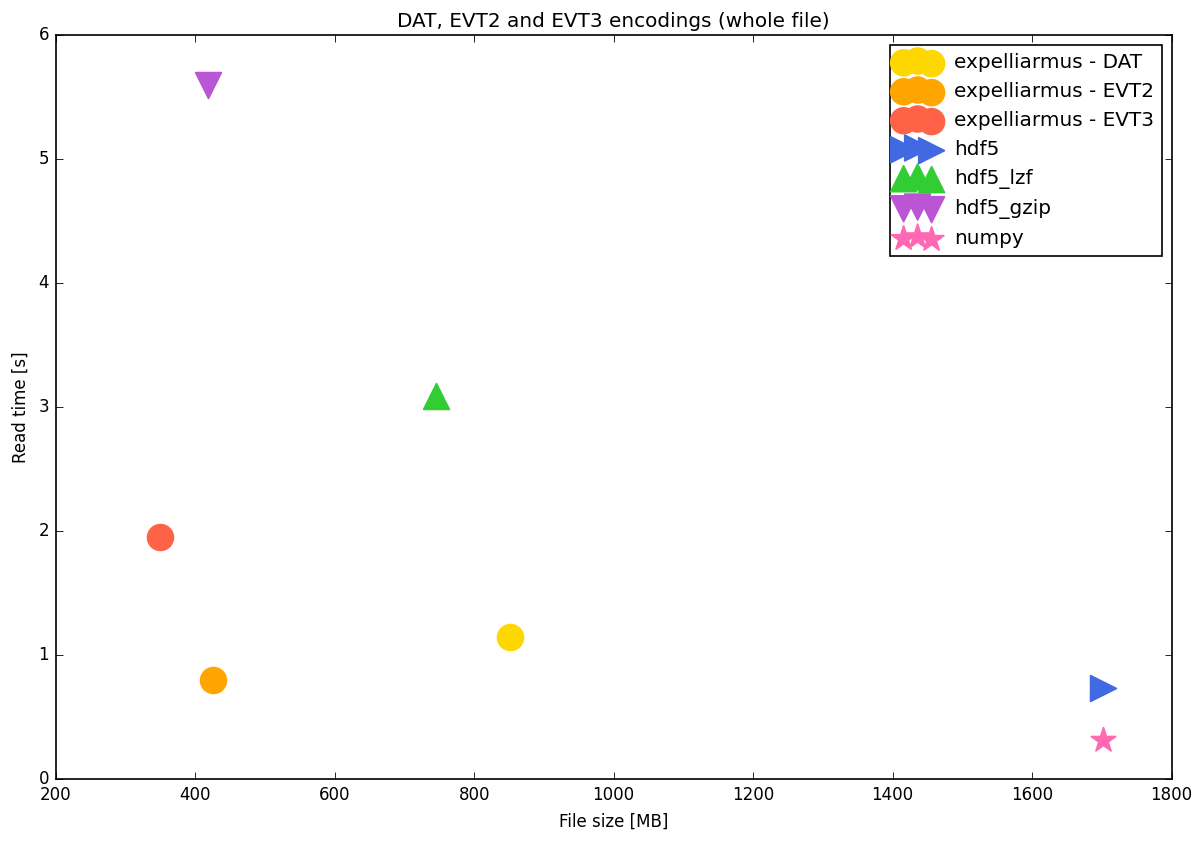

In [8]:
plt.clf()
fig = plt.figure(figsize=(12, 8), dpi=120)

plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT, EVT2 and EVT3 encodings (whole file)")

exp_colors = dict(dat="gold", evt2="orange", evt3="tomato")
sw_colors = dict(hdf5="royalblue", hdf5_lzf="limegreen", hdf5_gzip="mediumorchid", numpy="hotpink")
sw_markers = dict(hdf5=">", hdf5_lzf="^", hdf5_gzip="v", numpy="*")

# Expelliarmus
for encoding in encodings:
     plt.scatter(data["expelliarmus"][encoding]["fsize"], data["expelliarmus"][encoding]["full"], marker="o", s=240, color=exp_colors[encoding], label=f"expelliarmus - {encoding.upper()}")

# Other softwares.
for sw in softwares:
    plt.scatter(data[sw]["fsize"], data[sw]["full"], marker=sw_markers[sw], s=240, color=sw_colors[sw], label=sw)

plt.legend()
plt.show()

In [9]:
TIME_WINDOW = 20

print("Time windowing read")
arr_len = len(wizard.read(get_fpath("evt3")))
for encoding in encodings:

    if not LOAD_RESULTS:  
        fpath = pathlib.Path(get_fpath(encoding))
        wizard.set_encoding(encoding)
        wizard.set_file(fpath)
        wizard.set_time_window(TIME_WINDOW)
        time_window_length = len(next(wizard.read_time_window()))
        def fn():
            wizard.reset()
            return [window for window in wizard.read_time_window()]
            
        data["expelliarmus"][encoding]["windowed"] = sum(timeit.repeat(fn, number=1, repeat=REPEAT))/REPEAT

# HDF5 formats.
for sw in softwares[:-1]:
    fpath = pathlib.Path(f"ref_{sw}.hdf5")
    fp = h5py.File(fpath)
    data[sw]["windowed"] = sum(timeit.repeat(lambda: [fp["arr"][i*time_window_length:min(arr_len, (i+1)*time_window_length)] for i in range(arr_len//time_window_length)], number=1, repeat=REPEAT))/REPEAT
    fp.close()

header = f"Software  | Size [MB] | Diff. DAT | Diff. EVT2 | Diff. EVT3 | Time [s] | Diff. DAT | Diff. EVT2 | Diff. EVT3"
print("-"*len(header))
print(header)
print("-"*len(header))

for encoding in encodings:
    print(gen_row(f"exp. {encoding.upper()}", data["expelliarmus"][encoding]["fsize"], data["expelliarmus"][encoding]["windowed"], "windowed"))
    print("-"*len(header))

for sw in softwares[:-1]: 
    print(gen_row(sw, data[sw]["fsize"], data[sw]["windowed"], "windowed"))
    print("-"*len(header))

Time windowing read
------------------------------------------------------------------------------------------------------------
Software  | Size [MB] | Diff. DAT | Diff. EVT2 | Diff. EVT3 | Time [s] | Diff. DAT | Diff. EVT2 | Diff. EVT3
------------------------------------------------------------------------------------------------------------
exp. DAT  | 851       | -0%       | +100%      | +143%      | 1.58    | -0%       | +4%        | -39%       
------------------------------------------------------------------------------------------------------------
exp. EVT2 | 426       | -50%      | -0%        | +22%       | 1.51    | -4%       | -0%        | -42%       
------------------------------------------------------------------------------------------------------------
exp. EVT3 | 350       | -59%      | -18%       | -0%        | 2.58    | +64%      | +71%       | -0%        
------------------------------------------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

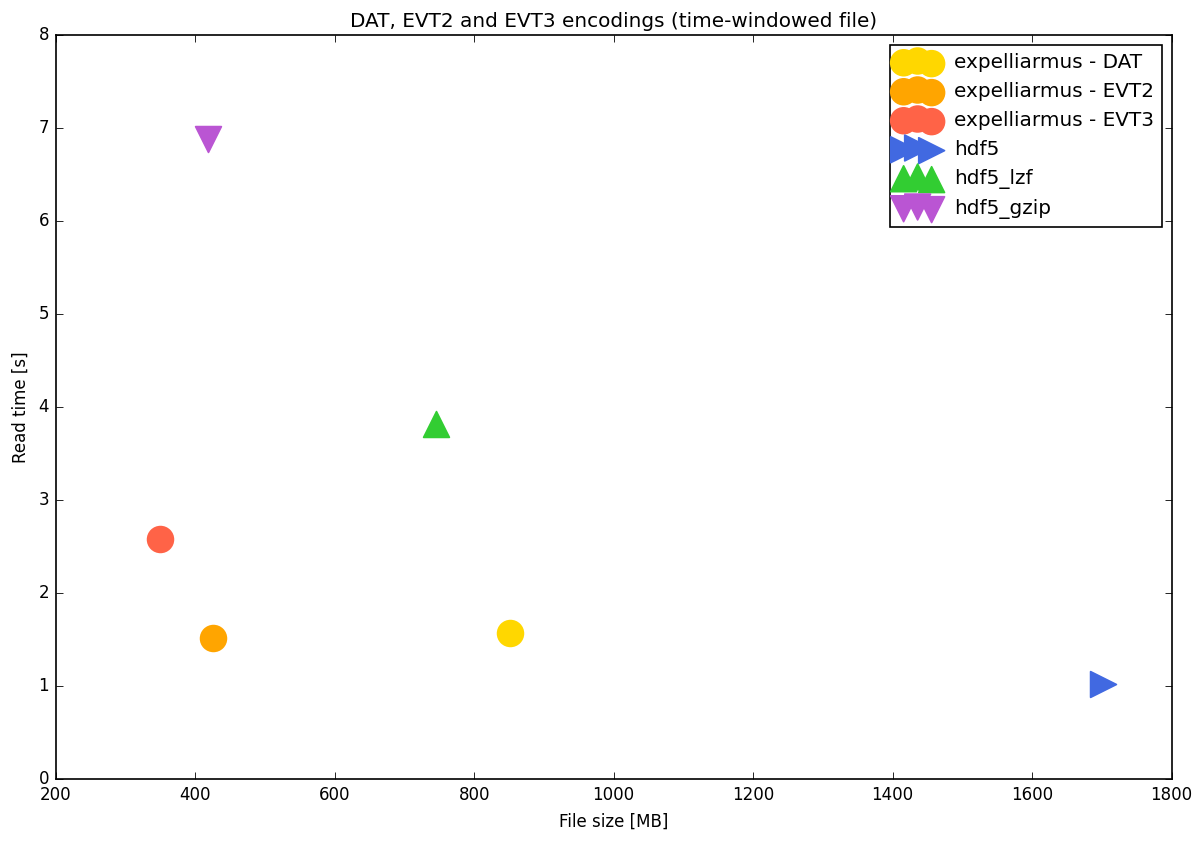

In [10]:
plt.clf()
fig = plt.figure(figsize=(12, 8), dpi=120)

plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT, EVT2 and EVT3 encodings (time-windowed file)")

# Expelliarmus
for encoding in encodings:
     plt.scatter(data["expelliarmus"][encoding]["fsize"], data["expelliarmus"][encoding]["windowed"], marker="o", s=240, color=exp_colors[encoding], label=f"expelliarmus - {encoding.upper()}")

# Other softwares.
for sw in softwares[:-1]:
    plt.scatter(data[sw]["fsize"], data[sw]["windowed"], marker=sw_markers[sw], s=240, color=sw_colors[sw], label=sw)

plt.legend()
plt.show()

In [11]:
CHUNK_LEN = 8192

print("Chunk read")
arr_len = len(wizard.read(get_fpath("evt3")))
for encoding in encodings:

    if not LOAD_RESULTS:  
        fpath = pathlib.Path(get_fpath(encoding))
        wizard.set_encoding(encoding)
        wizard.set_file(fpath)
        wizard.set_chunk_size(CHUNK_LEN)
        def fn():
            wizard.reset()
            return [chunk for chunk in wizard.read_chunk()]
            
        data["expelliarmus"][encoding]["chunked"] = sum(timeit.repeat(fn, number=1, repeat=REPEAT))/REPEAT

# HDF5 formats.
for sw in softwares[:-1]:
    fpath = pathlib.Path(f"ref_{sw}.hdf5")
    fp = h5py.File(fpath)
    data[sw]["chunked"] = sum(timeit.repeat(lambda: [fp["arr"][i*CHUNK_LEN:min(arr_len, (i+1)*CHUNK_LEN)] for i in range(arr_len//CHUNK_LEN)], number=1, repeat=REPEAT))/REPEAT
    fp.close()

header = f"Software  | Size [MB] | Diff. DAT | Diff. EVT2 | Diff. EVT3 | Time [s] | Diff. DAT | Diff. EVT2 | Diff. EVT3"
print("-"*len(header))
print(header)
print("-"*len(header))

for encoding in encodings:
    print(gen_row(f"exp. {encoding.upper()}", data["expelliarmus"][encoding]["fsize"], data["expelliarmus"][encoding]["chunked"], "chunked"))
    print("-"*len(header))

for sw in softwares[:-1]: 
    print(gen_row(sw, data[sw]["fsize"], data[sw]["chunked"], "chunked"))
    print("-"*len(header))

Chunk read
------------------------------------------------------------------------------------------------------------
Software  | Size [MB] | Diff. DAT | Diff. EVT2 | Diff. EVT3 | Time [s] | Diff. DAT | Diff. EVT2 | Diff. EVT3
------------------------------------------------------------------------------------------------------------
exp. DAT  | 851       | -0%       | +100%      | +143%      | 1.64    | -0%       | +3%        | -22%       
------------------------------------------------------------------------------------------------------------
exp. EVT2 | 426       | -50%      | -0%        | +22%       | 1.58    | -3%       | -0%        | -24%       
------------------------------------------------------------------------------------------------------------
exp. EVT3 | 350       | -59%      | -18%       | -0%        | 2.09    | +28%      | +32%       | -0%        
------------------------------------------------------------------------------------------------------------
hdf5    

<Figure size 432x288 with 0 Axes>

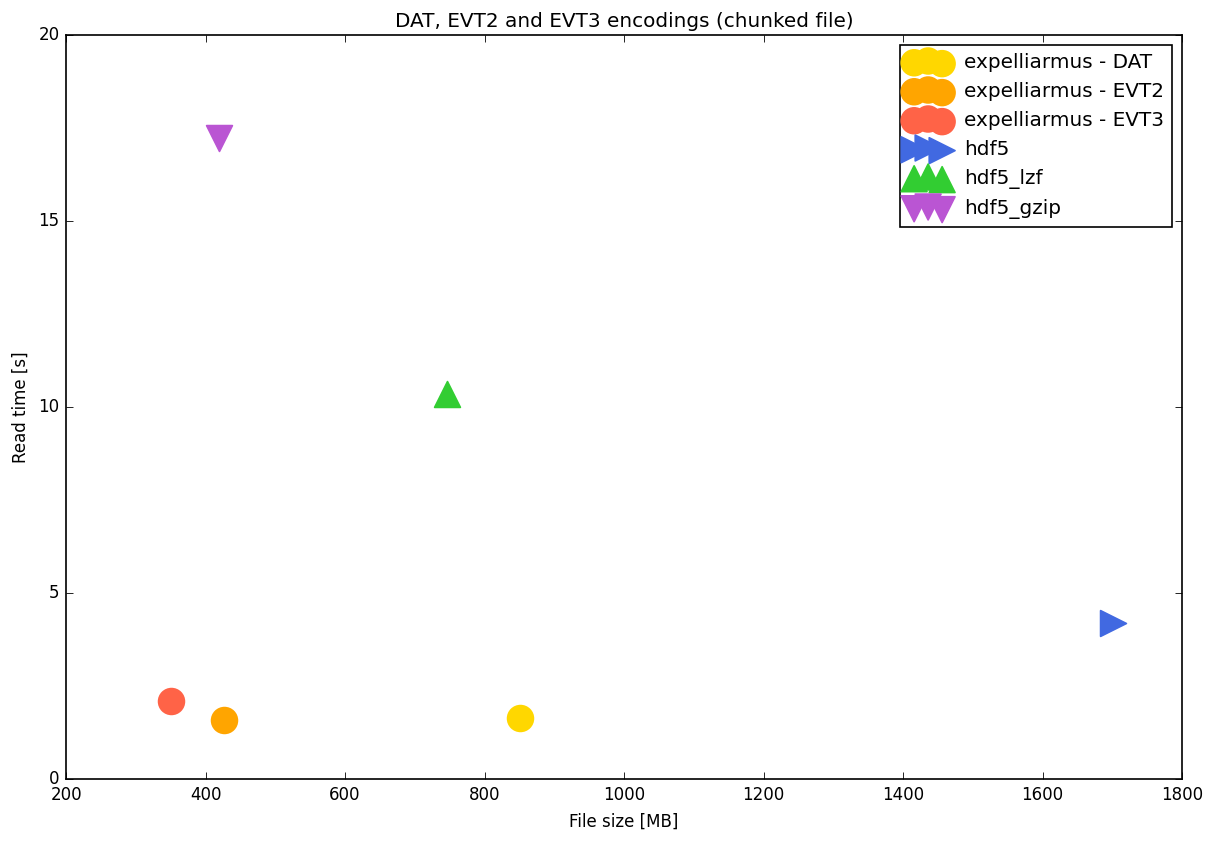

In [12]:
plt.clf()
fig = plt.figure(figsize=(12, 8), dpi=120)

plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT, EVT2 and EVT3 encodings (chunked file)")

# Expelliarmus
for encoding in encodings:
     plt.scatter(data["expelliarmus"][encoding]["fsize"], data["expelliarmus"][encoding]["chunked"], marker="o", s=240, color=exp_colors[encoding], label=f"expelliarmus - {encoding.upper()}")

# Other softwares.
for sw in softwares[:-1]:
    plt.scatter(data[sw]["fsize"], data[sw]["chunked"], marker=sw_markers[sw], s=240, color=sw_colors[sw], label=sw)

plt.legend()
plt.show()

In [13]:
if SAVE_RESULTS:
    pickle.dump(data, open("./benchmark.pk", "wb"))